# Radon transform denoising

# Part A

In [1]:
import astra
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import lsqr
from scipy import optimize
from skimage.draw import ellipse
from skimage.transform import resize, rescale, downscale_local_mean
import pywt
import copy

## Data exploration

In [2]:
f = np.load('SLphan.npy')
imFlat = f.flatten()
fPixels = f.size

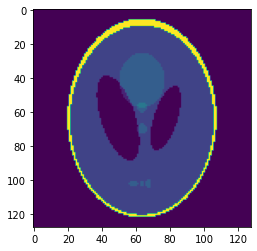

In [3]:
plt.imshow(f)

In [4]:
def projector(vol_geom, num_samples, num_angles=180, angle_range=np.pi):
    # Create projector geometries
    angles = np.linspace(0,angle_range,num_angles,endpoint=False)
    proj_geom = astra.create_proj_geom('parallel',1.,num_samples,angles)
    # Create projector
    return proj_geom, astra.create_projector('strip', proj_geom, vol_geom)

In [5]:
# Create volume geometries
v,h = f.shape
vol_geom = astra.create_vol_geom(v,h)
#define a number of samples to be taken
det_count = int(np.ceil(np.sqrt(v**2+h**2)))
proj_geom, projector_id = projector(vol_geom, det_count, 180, np.pi)
# Radon transform (generate sinogram)
sinogram_id, sinogram = astra.create_sino(f, projector_id)

(180, 182)


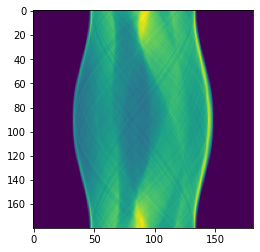

In [6]:
print(sinogram.shape)
plt.imshow(sinogram)

In [7]:
def backProject(projection_type, vol_geom, sinogram_id, projector_id):
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)
    # Set up the parameters for a reconstruction via back-projection
    cfg = astra.astra_dict(projection_type)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = projector_id
    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)
    # Run back-projection and get the reconstruction
    astra.algorithm.run(alg_id)
    f_rec = astra.data2d.get(rec_id)
    return f_rec

## Adequately sampled data without noise

In [8]:
f_rec_unfiltered = backProject("BP", vol_geom, sinogram_id, projector_id)
f_rec_filtered = backProject("FBP", vol_geom, sinogram_id, projector_id)

(128, 128) (128, 128)


[]

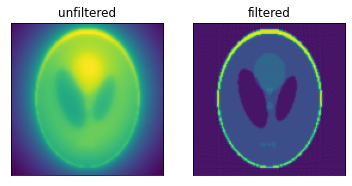

In [9]:
print(f_rec_unfiltered.shape, f_rec_filtered.shape)
fig, ax = plt.subplots(1, 2)
ax[0].set_title("unfiltered")
ax[0].imshow(f_rec_unfiltered)
ax[1].set_title("filtered")
ax[1].imshow(f_rec_filtered)
plt.setp(ax, xticks=[], yticks=[])

[]

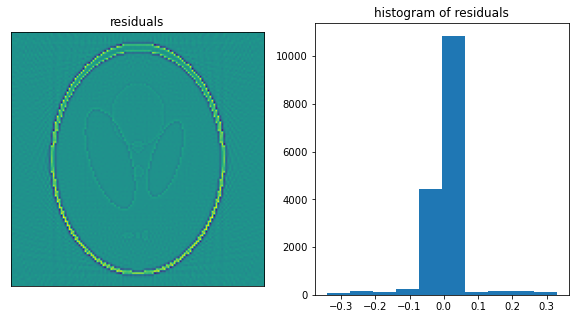

In [10]:
fig, ax = plt.subplots(1,2, figsize =(10, 5))
ax[0].set_title("residuals")
ax[0].imshow(f-f_rec_filtered)
ax[1].set_title("histogram of residuals")
ax[1].hist((f-f_rec_filtered).flatten())
plt.setp(ax[0], xticks=[], yticks=[])

Investigating the effects of the noise term on reconstruction error

In [11]:
#noisy data
theta = 500
gNoisy = astra.functions.add_noise_to_sino(sinogram,theta)
gNoisy_id = astra.data2d.create('-sino',proj_geom,gNoisy)

f_rec_noisy = backProject("FBP", vol_geom, gNoisy_id, projector_id)

[]

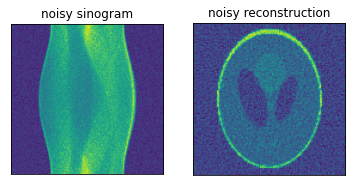

In [12]:
fig, ax = plt.subplots(1,2)
ax[0].set_title("noisy sinogram")
ax[0].imshow(gNoisy)
ax[1].set_title("noisy reconstruction")
ax[1].imshow(f_rec_noisy)
plt.setp(ax, xticks=[], yticks=[])

Text(0, 0.5, 'reconstruction error')

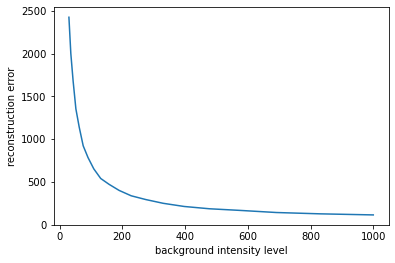

In [13]:
thetas = np.geomspace(30, 1000, 20)
error = []
for i in thetas:
    gNoisy = astra.functions.add_noise_to_sino(sinogram,i)
    gNoisy_id = astra.data2d.create('-sino',proj_geom,gNoisy)
    f_rec_noisy = backProject("FBP", vol_geom, gNoisy_id, projector_id)
    error.append(np.sum((f - f_rec_noisy)**2))

plt.plot(thetas, error)
plt.xlabel("background intensity level")
plt.ylabel("reconstruction error")

# Classical methods

In [14]:
def explicitA(imageH, imageW, num_samples, num_angles, angle_range=np.pi):
    imagePixels = imageH*imageW
    vol_geom = astra.create_vol_geom(imageH,imageW)
    projector_geom, projector_id = projector(vol_geom, num_samples, num_angles, angle_range)
    A = np.zeros((num_angles*num_samples, imagePixels))

    for i in range(imagePixels):
        image = np.zeros((imagePixels))
        image[i] = 1
        image = image.reshape(imageH, imageW)
        sinogram_id, sinogram = astra.create_sino(image, projector_id)
        A[:, i] = sinogram.flatten()
    return A

In [15]:
imageH, imageW = 64, 64
imagePixels = imageH*imageW
num_angles = 45
num_samples = 92

In [16]:
Asamples = explicitA(imageH, imageW, num_samples, num_angles, np.pi)
Arange = explicitA(imageH, imageW, num_samples, num_angles, np.pi/4)

Analysing information content through SVD.

In [17]:
u, SVDsamples, vh = np.linalg.svd(Asamples, full_matrices=True)
u, SVDrange, vh = np.linalg.svd(Arange, full_matrices=True)

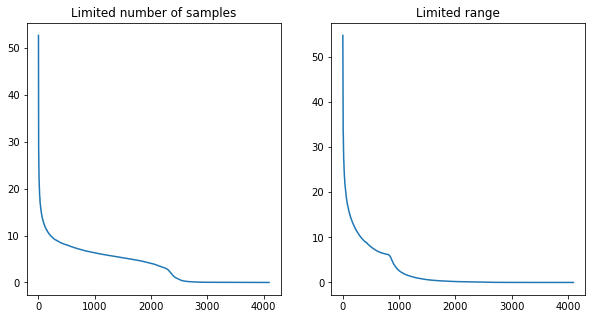

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Limited number of samples")
ax[0].plot(SVDsamples)
ax[1].set_title("Limited range")
ax[1].plot(SVDrange)

## Zero-order and First-order Tikhonov Regularisation

In [20]:
num_angles = 45
num_samples = 182
sinoPixels = num_angles*num_samples

In [21]:
#generating the undersampled and noisy data
proj_geom_sample, projector_id_sample = projector(vol_geom, num_samples, num_angles, np.pi)
A_sample = astra.OpTomo(projector_id_sample)
g_sample = astra.create_sino(f, projector_id_sample)[1]
gNoisy_sample = astra.functions.add_noise_to_sino(g_sample,500)
gNoisy_sample_id = astra.data2d.create('-sino',proj_geom_sample,gNoisy_sample)
fNoisy_sample = A_sample.T*gNoisy_sample.flatten()

proj_geom_range, projector_id_range = projector(vol_geom, num_samples, num_angles, np.pi/4)
A_range = astra.OpTomo(projector_id_range)
g_range = astra.create_sino(f, projector_id_range)[1]
gNoisy_range = astra.functions.add_noise_to_sino(g_range,500)
gNoisy_range_id = astra.data2d.create('-sino',proj_geom_range,gNoisy_range)
fNoisy_range = A_range.T*gNoisy_range.flatten()

In [22]:
#first-order finite difference of images
def diffMap(imFlat):
    image = imFlat.reshape(f.shape)
    Dx = np.concatenate((image[:, :-1] - image[:, 1:], np.zeros_like(image[:, [-1]])), axis=1)
    Dy = np.concatenate((image[:-1, :] - image[1:, :], np.zeros_like(image[[-1], :])), axis=0)
    return np.hstack([Dx.flatten(), Dy.flatten()])

def T_DiffMap(b):
    Dx = b[:fPixels].reshape(f.shape)
    Dy = b[fPixels:].reshape(f.shape)
    DxT = np.concatenate((Dx[:, [0]], np.concatenate((Dx[:, 1:-1], np.zeros_like(Dx[:, [0]])), axis=1) - Dx[:, :-1]), axis=1)
    DyT = np.concatenate((Dy[[0], :], np.concatenate((Dy[1:-1, :], np.zeros_like(Dy[[0], :])), axis=0) - Dy[:-1, :]), axis=0)
    return (DxT + DyT).flatten()

D = LinearOperator((2*fPixels,fPixels), matvec=diffMap, rmatvec=T_DiffMap)
I = LinearOperator((fPixels, fPixels), matvec=lambda f:f, rmatvec=lambda f:f)

In [23]:
expectedError_sample = np.sum((g_sample - gNoisy_sample)**2)
expectedError_range = np.sum((g_range - gNoisy_range)**2)

In [24]:
def DP(alpha, A, G, expected_error):
    ATA = LinearOperator((fPixels,fPixels), matvec= lambda f : A.T*A*f + alpha*(G.H*G*f))
    output = gmres(ATA, A.T*gNoisy_sample.flatten(), tol=1e-4)
    r = gNoisy_sample.flatten() - A*output[0]
    return r@r - expected_error

In [ ]:
#finding optimal regularisation parameters
alpha_0_sample = optimize.root(DP, 105, args=(A_sample, I, expectedError_sample)).x[0]
alpha_1_sample = optimize.root(DP, 158, args=(A_sample, D, expectedError_sample)).x[0]
alpha_0_range = optimize.root(DP, 4, args=(A_range, I, expectedError_range)).x[0]
alpha_1_range = optimize.root(DP, 12, args=(A_range, D, expectedError_range)).x[0]

In [26]:
ATA_0_sample = LinearOperator((fPixels,fPixels), matvec= lambda f : A_sample.T*A_sample*f + alpha_0_sample*f)
ATA_1_sample = LinearOperator((fPixels,fPixels), matvec= lambda f : A_sample.T*A_sample*f + alpha_1_sample*D.H*D*f)
ATA_0_range = LinearOperator((fPixels,fPixels), matvec= lambda f : A_range.T*A_range*f + alpha_0_range*f)
ATA_1_range = LinearOperator((fPixels,fPixels), matvec= lambda f : A_range.T*A_range*f + alpha_1_range*D.H*D*f)

gmresOutput_0_sample = gmres(ATA_0_sample, A_sample.T*gNoisy_sample.flatten(), tol=1e-4)
gmresOutput_1_sample = gmres(ATA_1_sample, A_sample.T*gNoisy_sample.flatten(), tol=1e-4)
gmresOutput_0_range = gmres(ATA_0_range, A_range.T*gNoisy_range.flatten(), tol=1e-4)
gmresOutput_1_range = gmres(ATA_1_range, A_range.T*gNoisy_range.flatten(), tol=1e-4)

FBP_sample = backProject("FBP", vol_geom, gNoisy_sample_id, projector_id_sample)
FBP_range = backProject("FBP", vol_geom, gNoisy_range_id, projector_id_range)

[]

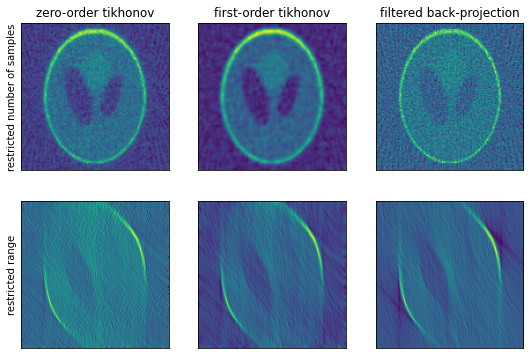

In [27]:
#Reconstruction results
fig, ax = plt.subplots(2,3, figsize=(9, 6))
ax[0,0].set_title("zero-order tikhonov")
ax[0,1].set_title("first-order tikhonov")
ax[0,2].set_title("filtered back-projection")
ax[0,0].set(ylabel="restricted number of samples")
ax[1,0].set(ylabel="restricted range")

ax[0,0].imshow(gmresOutput_0_sample[0].reshape(f.shape))
ax[0,1].imshow(gmresOutput_1_sample[0].reshape(f.shape))
ax[0,2].imshow(FBP_sample)
ax[1,0].imshow(gmresOutput_0_range[0].reshape(f.shape))
ax[1,1].imshow(gmresOutput_1_range[0].reshape(f.shape))
ax[1,2].imshow(FBP_range)

plt.setp(ax, xticks=[], yticks=[])

[]

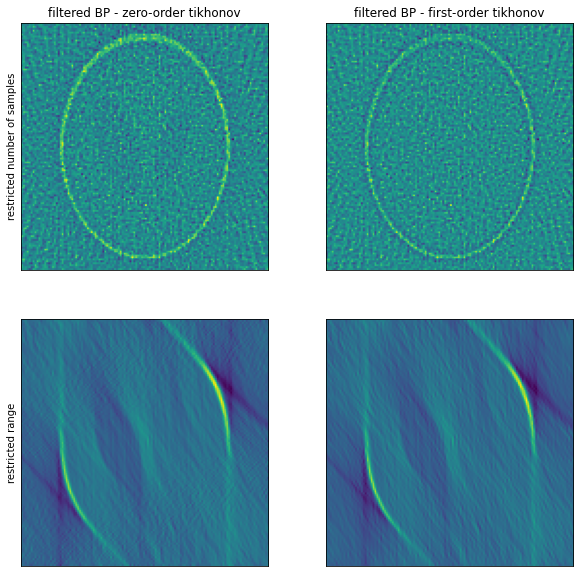

In [28]:
# error in reconstructions
fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax[0,0].set_title("filtered BP - zero-order tikhonov")
ax[0,1].set_title("filtered BP - first-order tikhonov")
ax[0,0].set(ylabel="restricted number of samples")
ax[1,0].set(ylabel="restricted range")
ax[0,0].imshow(FBP_sample - gmresOutput_0_sample[0].reshape(f.shape))
ax[0,1].imshow(FBP_sample - gmresOutput_1_sample[0].reshape(f.shape))
ax[1,0].imshow(FBP_range - gmresOutput_0_range[0].reshape(f.shape))
ax[1,1].imshow(FBP_range - gmresOutput_1_range[0].reshape(f.shape))
plt.setp(ax, xticks=[], yticks=[])

## Haar Wavelet regularisation

In [29]:
coeffs = pywt.wavedec2(f,'haar')

In [31]:
f_wavrec = pywt.waverec2(coeffs,'haar')

[]

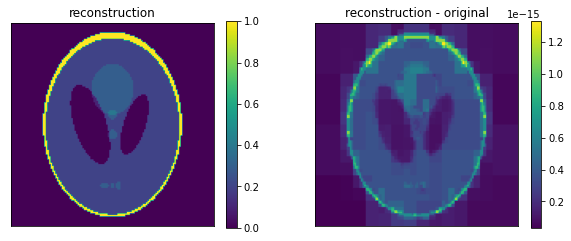

In [56]:
fig, ax = plt.subplots(1,2, figsize=(10, 3.8))
ax[0].set_title("reconstruction")
ax[1].set_title("reconstruction - original")
rec = ax[0].imshow(f_wavrec)
res = ax[1].imshow(f_wavrec - f)
plt.colorbar(rec, ax=ax[0])
plt.colorbar(res, ax=ax[1])
# fig.colorbar(res, ax=fig.get_axes())
plt.setp(ax, xticks=[], yticks=[])

In [33]:
def thresholdFunction(coeffs, level, percentile=None, value=None):
    #index of section of coefficients to mask out
    ignore = 2**(len(coeffs)-1-level)
    #make array from coefficients
    array, slices = pywt.coeffs_to_array(coeffs)
    #save unaltered coefficients to be reinserted later
    untouched_coeffs = array[:ignore, :ignore].copy()
    #soft threshold remaining coefficients, using fixed or relative value
    if percentile is not None:
        #using value as a percentile of coefficients
        array[:ignore, :ignore] = np.inf
        quantile_value = np.percentile(np.abs(array), percentile)
    else:
        quantile_value = value
    array_thresh = pywt.threshold(array, quantile_value, substitute=0)
    #replace untouched coefficients and convert array back to standard format
    array_thresh[:ignore, :ignore] = untouched_coeffs
    coeffsT = pywt.array_to_coeffs(array_thresh, slices, output_format='wavedec2')
    return coeffsT

[]

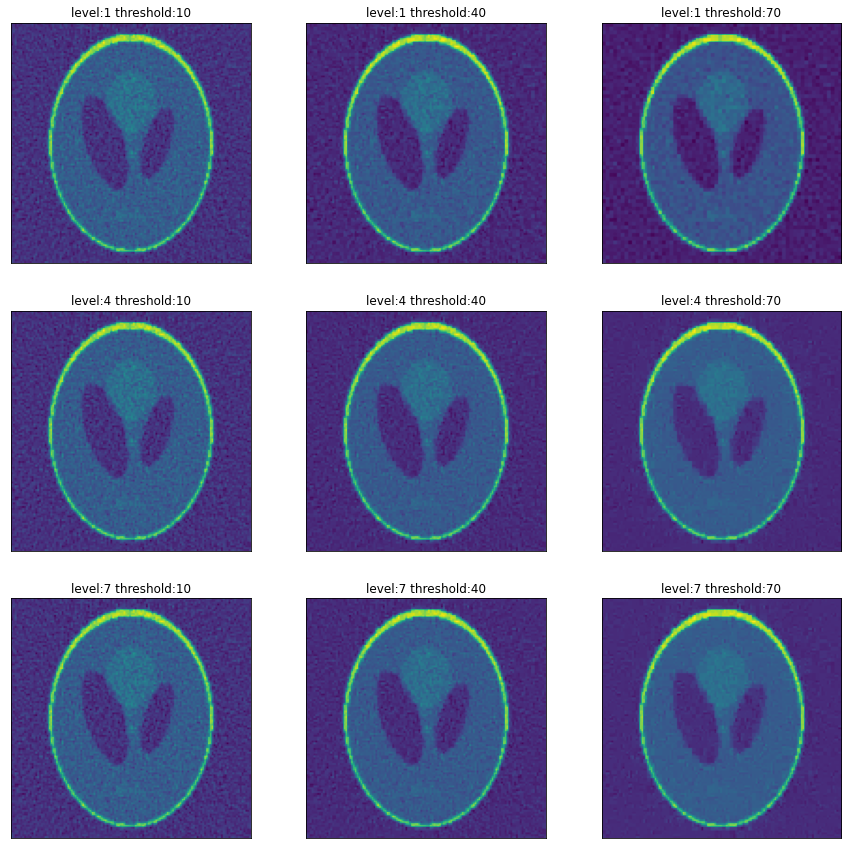

In [34]:
#results from thresholding different wavelet coefficients by varying amounts
levels = [1, 4, 7]
thresholds = [10, 40, 70]
fig, ax= plt.subplots(3, 3, figsize=(15, 15))

coeffs = pywt.wavedec2(f_rec_noisy,'haar')
for i, level in enumerate(levels):
    for j, threshold in enumerate(thresholds):
        ax[i,j].set_title("level:"+str(level)+" threshold:"+str(threshold))
        ax[i,j].imshow(pywt.waverec2(thresholdFunction(coeffs, level, percentile=threshold),'haar'))
plt.setp(ax, xticks=[], yticks=[])

## Iterative regularisation using haar wavelet coefficients

In [60]:
W = lambda vector: pywt.wavedec2(vector.reshape(f.shape),'haar')
Winv = lambda coeffs: pywt.waverec2(coeffs,'haar').flatten()
A = astra.OpTomo(projector_id)

In [61]:
def ISTA(alpha, step_size, A, g, tol=0, steps=100):
    f0 = A.T*g
    fk = f0
    errors = []
    converge = []
    for i in range(steps):
        # gradient update
        fk = fk - step_size*A.T*(A*fk - g)
        #projection for non-negativity prior
        fk[fk<0] = 0
        fk = Winv(thresholdFunction(W(fk), level=4, value=step_size*alpha))
        errors.append(np.sum((imFlat-fk)**2))
        converge.append(np.sum((fk)**2))
        if i > 0 and abs(converge[-1]-converge[-2]) / converge[-2] < tol: break
    return fk, errors, converge

/home/callum/anaconda3/envs/astra2/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in float_scalars
  


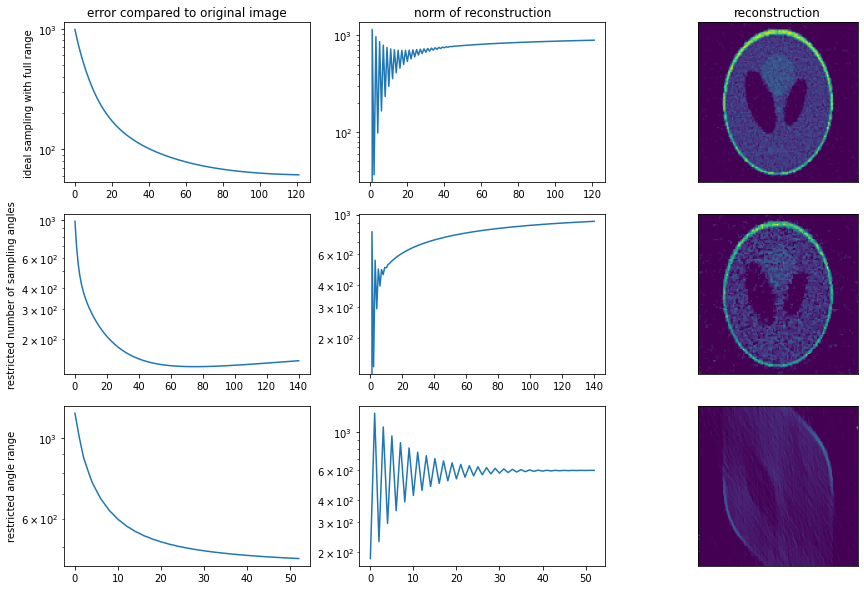

In [219]:
lamb = 1e-4#8e-5
alpha = 4e0
tol = 1e-3
fks = []
errors = []
converges = []
fk, error, converge = ISTA(4e0, 9e-5, A, gNoisy.flatten(), tol=tol, steps=300)
fks.append(fk); errors.append(error); converges.append(converge)
fk, error, converge = ISTA(4e0, 3e-4, A_sample, gNoisy_sample.flatten(), tol=tol, steps=300)
fks.append(fk); errors.append(error); converges.append(converge)
fk, error, converge = ISTA(4e0, 3.2e-4, A_range, gNoisy_range.flatten(), tol=tol, steps=300)
fks.append(fk); errors.append(error); converges.append(converge)

fig, ax= plt.subplots(3, 3, figsize=(15, 10))
ax[0,0].set_title("error compared to original image")
ax[0,1].set_title("norm of reconstruction")
ax[0,2].set_title("reconstruction")
ax[0,0].set(ylabel="ideal sampling with full range")
ax[1,0].set(ylabel="restricted number of sampling angles")
ax[2,0].set(ylabel="restricted angle range")
for i in range(3):
    ax[i,0].semilogy(errors[i])
    ax[i,1].semilogy(converges[i])
    ax[i,2].imshow(fks[i].reshape(f.shape))
    plt.setp(ax[i,2], xticks=[], yticks=[])

# Deep Learning approaches

Two different approaches will be investigated. 
The first directly attempts to improve the output of the filtered backprojected radon transform.
The second method uses the gradients of a backprojection step to aid the network to produce an output. Multiple iterations of this process are performed to produce an output. 

In [ ]:
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import gc
import GPUtil
import math
from torchsummary import summary
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
#helper functions
def FPandCUDA(tensors, FP="float", device="cuda"):
    dev = torch.device(device)
    if isinstance(tensors, list):
        if FP=="float":
            return [tensor.float().to(dev) for tensor in tensors]
        else:
            return [tensor.half().to(dev) for tensor in tensors]
    else:
        if FP=="float":
            return tensors.float().to(dev)
        else:
            return tensor.half().to(dev)

## Generate data to train model with

In [75]:
Asamples = torch.from_numpy(explicitA(imageH, imageW, num_samples, num_angles, np.pi)).float()

In [113]:
num_angles = 45#     8*22 #176
num_samples = 92#    8*12 #96
angle_range = np.pi
vol_geom = astra.create_vol_geom(imageH,imageW)
projector_geom, projector_id = projector(vol_geom, num_samples, num_angles, angle_range)
Aoperator = astra.OpTomo(projector_id)

In [210]:
# Generate test data at varying levels of noise
f64 = rescale(f, 0.5)
sino64 = (Aoperator*f64).reshape(num_angles, num_samples)
thetas = [100, 300, 900, 1500, 2000, "no noise"]#np.geomspace(30, 1000, 6)
X = np.zeros((6, 64, 64))
G = np.zeros((6, num_angles, num_samples))
for i in range(5):
    G[i] = astra.functions.add_noise_to_sino(sino64,thetas[i])
    gNoisy_id = astra.data2d.create('-sino',projector_geom,G[i])
    X[i] = backProject("FBP", vol_geom, gNoisy_id, projector_id)
G[5] = sino64
gNoisy_id = astra.data2d.create('-sino',projector_geom,G[5])
X[5] = backProject("FBP", vol_geom, gNoisy_id, projector_id)
X, G = torch.from_numpy(X).float().unsqueeze(1), torch.from_numpy(G).float()

In [181]:
def gen_data(size, vol_geom, projector_geom, projector_id, variable_noise=False):
    param_range = np.array([34, 34, 14, 14, 2*np.pi, 5])
    param_offset = np.array([15, 15, 1, 1, -np.pi, 1])
    X = np.zeros((size, 64, 64))
    Y = np.zeros((size, 64, 64))
    G = np.zeros((size, num_angles, num_samples))
    for i in range(size):
        # draw a random number of ellipses
        for j in range(np.random.randint(5,21)):
            params = np.random.rand(6)*param_range + param_offset
            rr, cc = ellipse(params[0], params[1], params[2], params[3], (64, 64), params[4])
            Y[i, rr, cc] += params[5]
        Y[i] /= np.max(Y[i])
        noise = np.random.randint(100, 2000) if variable_noise else 1500
        G[i] = astra.functions.add_noise_to_sino((Aoperator*Y[i]).reshape(num_angles, num_samples),noise)
        gNoisy_id = astra.data2d.create('-sino',projector_geom,G[i])
        X[i] = backProject("FBP", vol_geom, gNoisy_id, projector_id)
    X, G, Y = torch.from_numpy(X).float(), torch.from_numpy(G).float(), torch.from_numpy(Y).float()
    X = X.unsqueeze_(1)
    return X, G, Y

In [26]:
#fixed noise level experiments
#training data
X, G, Y = gen_data(10000, vol_geom, projector_geom, projector_id)
trn_data = torch.utils.data.TensorDataset(X, Y)
MB_trn_data = torch.utils.data.TensorDataset(X, G, Y)

#validation data
X, G, Y = gen_data(300, vol_geom, projector_geom, projector_id)
val_data = torch.utils.data.TensorDataset(X, Y)
MB_val_data = torch.utils.data.TensorDataset(X, G, Y)

In [177]:
# variable noise level experiments
#training data
X, G, Y = gen_data(10000, vol_geom, projector_geom, projector_id, variable_noise=True)
trn_data_varNoise = torch.utils.data.TensorDataset(X, Y)
MB_trn_data_varNoise = torch.utils.data.TensorDataset(X, G, Y)

#validation data
X, G, Y = gen_data(300, vol_geom, projector_geom, projector_id, variable_noise=True)
val_data_varNoise = torch.utils.data.TensorDataset(X, Y)
MB_val_data_varNoise = torch.utils.data.TensorDataset(X, G, Y)

In [202]:
#save data to avoid recreating dataset each time
torch.save(Asamples, 'Asamples.pth')
torch.save(trn_data, 'trn_data.pth')
torch.save(val_data, 'val_data.pth')
torch.save(MB_trn_data, 'MB_trn_data.pth')
torch.save(MB_val_data, 'MB_val_data.pth')
torch.save(trn_data_varNoise, 'trn_data_varNoise.pth')
torch.save(val_data_varNoise, 'val_data_varNoise.pth')
torch.save(MB_trn_data_varNoise, 'MB_trn_data_varNoise.pth')
torch.save(MB_val_data_varNoise, 'MB_val_data_varNoise.pth')

In [74]:
#load dataset
num_angles = 45
num_samples = 92
Asamples = torch.load('Asamples.pth')
trn_data = torch.load('trn_data.pth')
val_data = torch.load('val_data.pth')
MB_trn_data = torch.load('MB_trn_data.pth')
MB_val_data = torch.load('MB_val_data.pth')
trn_data_varNoise = torch.load('trn_data_varNoise.pth')
val_data_varNoise = torch.load('val_data_varNoise.pth')
MB_trn_data_varNoise = torch.load('MB_trn_data_varNoise.pth')
MB_val_data_varNoise = torch.load('MB_val_data_varNoise.pth')

In [203]:
batch_size = 8
trn_DL = DataLoader(trn_data, batch_size=batch_size, shuffle=True)
val_DL = DataLoader(val_data, batch_size=batch_size)
MB_trn_DL = DataLoader(MB_trn_data, batch_size=batch_size, shuffle=True)
MB_val_DL = DataLoader(MB_val_data, batch_size=batch_size)
trn_DL_varNoise = DataLoader(trn_data, batch_size=batch_size, shuffle=True)
val_DL_varNoise = DataLoader(val_data, batch_size=batch_size)
MB_trn_DL_varNoise = DataLoader(MB_trn_data, batch_size=batch_size, shuffle=True)
MB_val_DL_varNoise = DataLoader(MB_val_data, batch_size=batch_size)

In [76]:
# function to save model parameters, which is used in early stopping to save the model
# at the epoch with best validation accuracy, before the model overfits the training data
def save_checkpoint(state, ep, filename='checkpoint.pth.tar'):
    """Save checkpoint if a new best is achieved"""
    torch.save(state, filename)  # save checkpoint

def evalModel(dataLoader, model, loss_func, precision="float"):
    total_loss = 0
    correct = 0
    model.to(device)
    model.eval()
    
    for i, data in enumerate(dataLoader):
        data = FPandCUDA(data, precision)
        out = model(*data[:-1])
        loss = loss_func(out, data[-1])
        total_loss += loss.item()

    return total_loss/len(dataLoader.dataset) 

In [171]:
#model definitions

#model components
class ResnetBlock(nn.Module):
    def __init__(self, input_channels, intermediate_channels, kernel1, kernel2):
        super(ResnetBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, intermediate_channels, kernel1, padding=kernel1//2)
        self.conv2 = nn.Conv2d(intermediate_channels, 1, kernel2, padding=kernel2//2)

    def forward(self, x):
        x_conv = self.conv2(F.relu(self.conv1(x)))
        return F.relu(x[:, 0].unsqueeze(1) + x_conv)

    
class gradConcatBlock(nn.Module):
    def __init__(self, A):
        super(gradConcatBlock, self).__init__()
        #A is 1 x num_angles*num_samples x 64*64
        self.At = nn.Parameter(A.unsqueeze(0).transpose(1, 2), requires_grad=False)
        self.AtA = nn.Parameter(self.At@A, requires_grad=False)
        
    def forward(self, x, g):
        gradient = (self.AtA@x.view(-1, 64*64, 1) - self.At@g).view(-1, 1, 64, 64)
        return torch.cat((x, gradient), 1)
    

#first model, only applying post-processing to the output of filtered backprojection
class postProcModel(nn.Module):
    def __init__(self, hidden, layers, kernel1, kernel2):
        super(postProcModel, self).__init__()
        self.sequential = nn.Sequential(*[ResnetBlock(1, hidden, kernel1, kernel2) for _ in range(layers)])

    def forward(self, x):
        return self.sequential(x).squeeze()


#second model, using backprojection gradients to aid reconstruction
class MB_iterativeModel(nn.Module):
    def __init__(self, hidden, layers, kernel1, kernel2, A):
        super(MB_iterativeModel, self).__init__()
        self.resBlocks = nn.ModuleList([ResnetBlock(2, hidden, kernel1, kernel2) for _ in range(layers)])
        self.gradConcatBlock = gradConcatBlock(A)
        
    def forward(self, x, g):
        out = x
        g = g.view(-1, num_angles*num_samples, 1)
        for resBlock in self.resBlocks:
            out = self.gradConcatBlock(out, g)
            out = resBlock(out)
        return out.squeeze()

In [80]:
def trainModel(net, epochs, lr, trnDL, valDL, testDL=None, params=[], saveModel=False, precision="float", pretrainedPath=None, countFrom=0):
            
    # lists to store progress of the model at each epoch
    trnLoss = []
    valLoss = []
    testLoss = []

    model = net(*params)
    if pretrainedPath is not None: model.load_state_dict(torch.load(pretrainedPath))
    model = FPandCUDA(model, precision)
    loss_func = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr*10, steps_per_epoch=len(trnDL), epochs=epochs)

    for epoch in range(epochs):
        model.train()

        # train weights
        for i, data in enumerate(trnDL):
            data = FPandCUDA(data, precision)
            model.zero_grad()
            out = model(*data[:-1])
            loss = loss_func(out, data[-1])
            loss.backward()
            optimizer.step()
            scheduler.step()
            del data, out, loss

        # after each epoch, calculate unregularised loss and accuracy
        if epoch%5 == 0:
            with torch.no_grad():
                trnLoss.append(evalModel(trnDL, model, loss_func, precision))
                valLoss.append(evalModel(valDL, model, loss_func, precision))
                if testDL is not None:
                    testLoss.append(evalModel(testDL, model, loss_func, precision))
                print(trnLoss[-1], valLoss[-1])

                
        if epoch%10 == 9:
            save_checkpoint(model.state_dict(), epoch, filename=model.__class__.__name__+str(countFrom)+'checkpoint.pth.tar')
            countFrom += 1

    if testDL is not None:
        return trnLoss, valLoss, testLoss
    else:
        return trnLoss, valLoss

### Training Model-based approach

In [ ]:
hidden, resBlocks, kernel1, kernel2 = 10, 5, 3, 3
trnLoss, valLoss = trainModel(MB_iterativeModel, 100, 1e-6, MB_trn_DL, MB_val_DL, params=[hidden, resBlocks, kernel1, kernel2, Asamples], countFrom=40)#, pretrainedPath="MB_iterativeModel35checkpoint.pth.tar", )

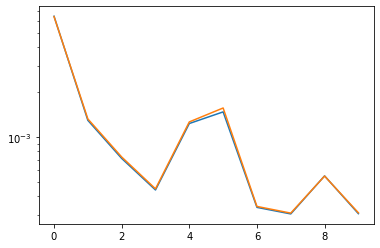

In [88]:
plt.semilogy(trnLoss)
plt.semilogy(valLoss)

[]

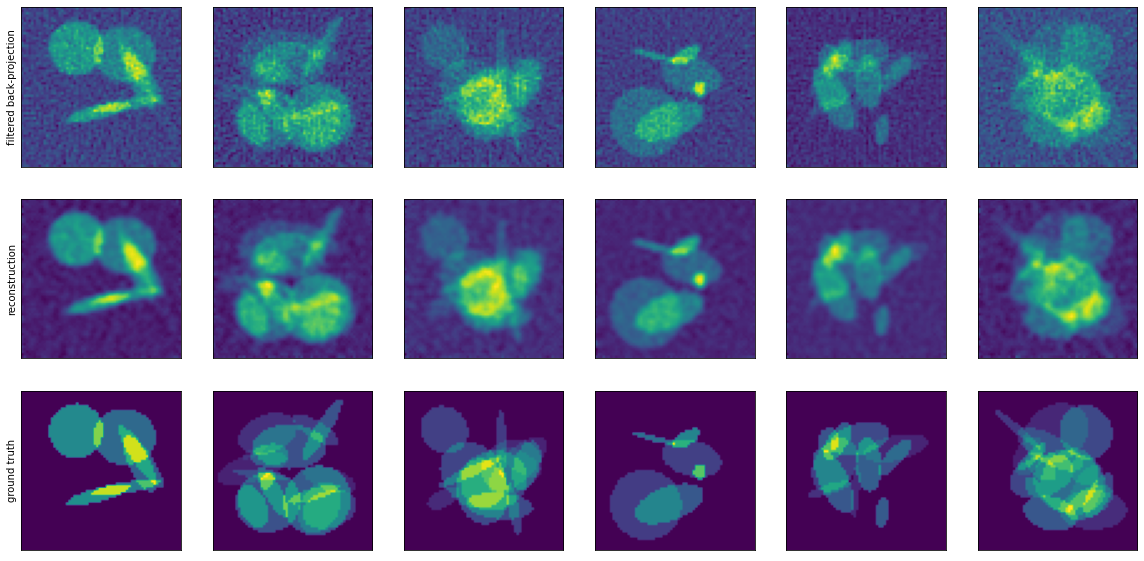

In [167]:
#results of model-based approach on validation set
hidden, resBlocks, kernel1, kernel2 = 10, 5, 3, 3
data = next(iter(MB_trn_DL))
data = FPandCUDA(data, "float", "cpu")
with torch.no_grad():
    model = FPandCUDA(MB_iterativeModel(10, 5, kernel1, kernel2, Asamples), "float", "cpu")
    model.load_state_dict(torch.load("MB_iterativeModel35checkpoint.pth.tar"))
rec = model(*data[:-1]).detach()
_, ax = plt.subplots(3, 6, figsize=(20, 10))
ax[0,0].set(ylabel="filtered back-projection")
ax[1,0].set(ylabel="reconstruction")
ax[2,0].set(ylabel="ground truth")
for i in range(6):
    ax[0,i].imshow(data[0][i, 0])
    ax[1,i].imshow(rec[i])
    ax[2,i].imshow(data[2][i])
plt.setp(ax, xticks=[], yticks=[])

torch.float32


[]

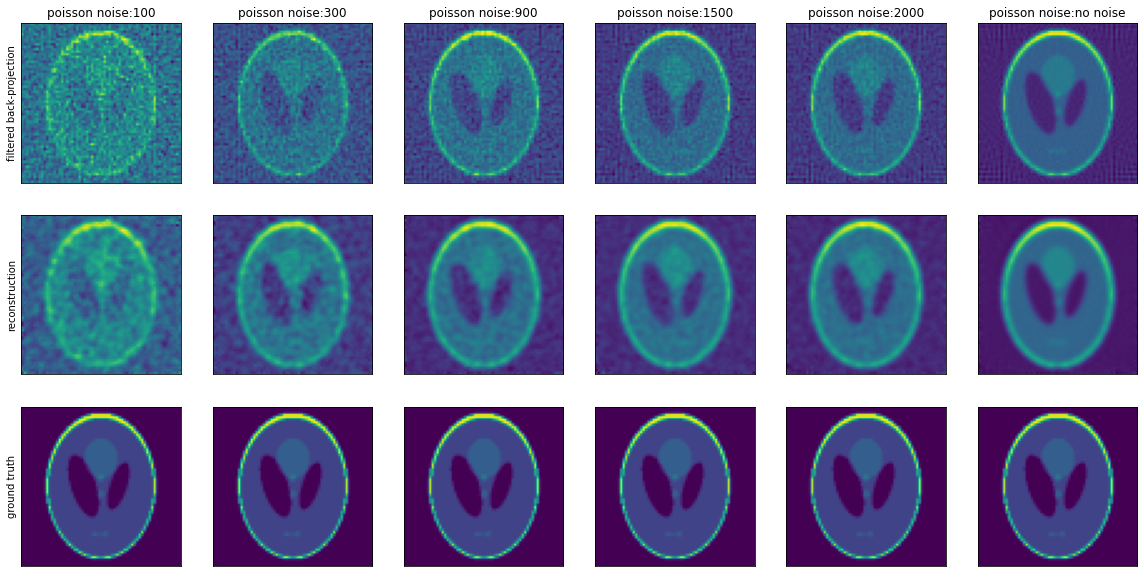

In [168]:
#results on test data of varying noise levels
rec = model(X, G).detach()
print(rec.dtype)
_, ax = plt.subplots(3, 6, figsize=(20, 10))
ax[0,0].set(ylabel="filtered back-projection")
ax[1,0].set(ylabel="reconstruction")
ax[2,0].set(ylabel="ground truth")
for i in range(6):
    ax[0, i].set_title("poisson noise:"+str(thetas[i]))
    ax[0,i].imshow(X[i, 0])
    ax[1,i].imshow(rec[i])
    ax[2,i].imshow(f64)
plt.setp(ax, xticks=[], yticks=[])

### Train Post processing based

In [ ]:
hidden, resBlocks, kernel1, kernel2 = 12, 20, 9, 5
trnLoss, valLoss = trainModel(postProcModel, 101, 1e-4, trn_DL, val_DL, params=[hidden,resBlocks, kernel1, kernel2], countFrom=0)

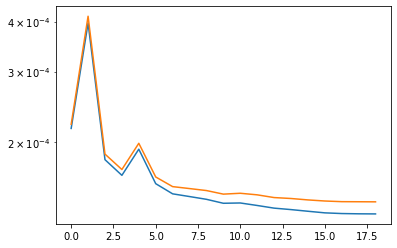

In [87]:
plt.semilogy(trnLoss[2:])
plt.semilogy(valLoss[2:])

[]

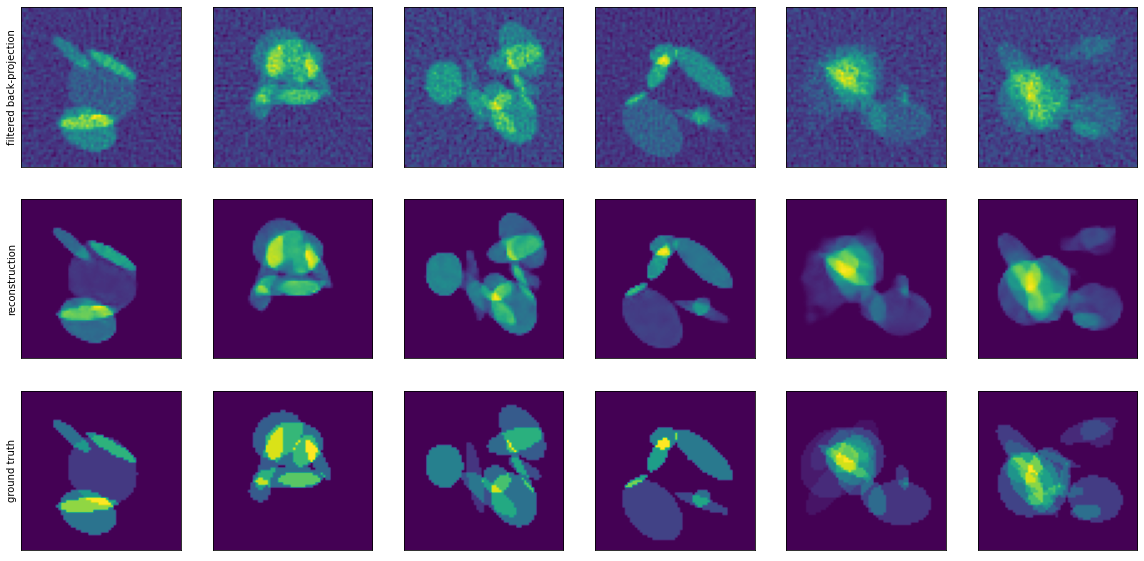

In [213]:
#results on validation data
hidden, resBlocks, kernel1, kernel2 = 10, 20, 9, 5
data = next(iter(trn_DL))
data = FPandCUDA(data, "float", "cpu")
with torch.no_grad():
    model = FPandCUDA(postProcModel(hidden, resBlocks, kernel1, kernel2), "float", "cpu")
    model.load_state_dict(torch.load("postProcModel39checkpoint.pth.tar"))
rec = model(*data[:-1]).detach()
_, ax = plt.subplots(3, 6, figsize=(20, 10))
ax[0,0].set(ylabel="filtered back-projection")
ax[1,0].set(ylabel="reconstruction")
ax[2,0].set(ylabel="ground truth")
for i in range(6):
    ax[0,i].imshow(data[0][i, 0])
    ax[1,i].imshow(rec[i])
    ax[2,i].imshow(data[1][i])
plt.setp(ax, xticks=[], yticks=[])

torch.float32


[]

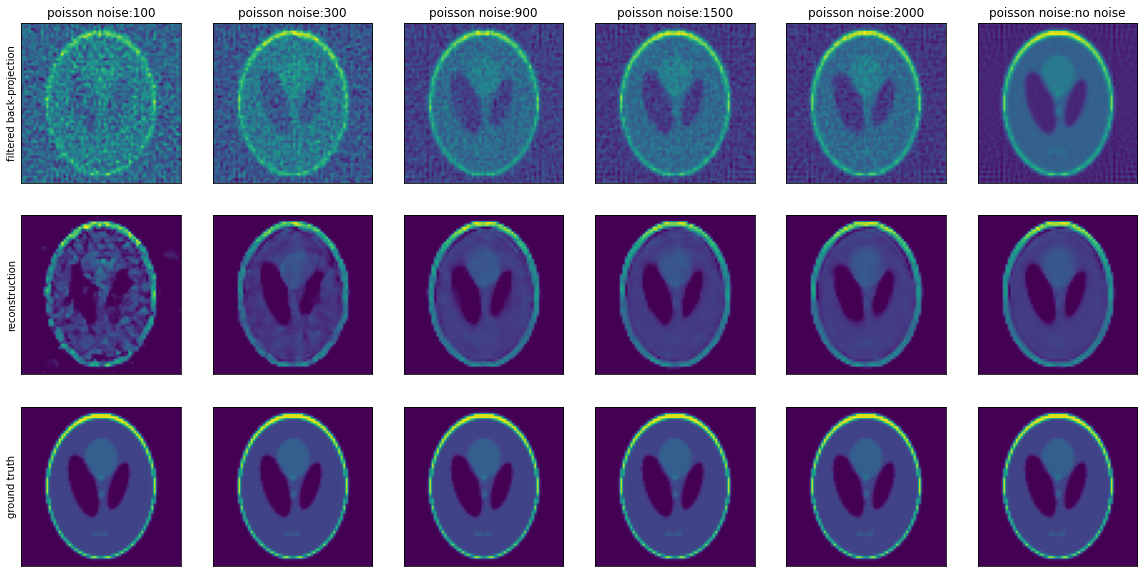

In [214]:
#results on test data of variable noise levels
rec = model(X).detach()
print(rec.dtype)
_, ax = plt.subplots(3, 6, figsize=(20, 10))
ax[0,0].set(ylabel="filtered back-projection")
ax[1,0].set(ylabel="reconstruction")
ax[2,0].set(ylabel="ground truth")
for i in range(6):
    ax[0, i].set_title("poisson noise:"+str(thetas[i]))
    ax[0,i].imshow(X[i, 0])
    ax[1,i].imshow(rec[i])
    ax[2,i].imshow(f64)
plt.setp(ax, xticks=[], yticks=[])

### Training post-processing model on variable noise
The data used to train the model has a variety of noise levels

In [ ]:
hidden, resBlocks, kernel1, kernel2 = 10, 20, 9, 5
trnLoss, valLoss = trainModel(postProcModel, 101, 1e-4, trn_DL_varNoise, val_DL_varNoise, params=[hidden,resBlocks, kernel1, kernel2], countFrom=30)

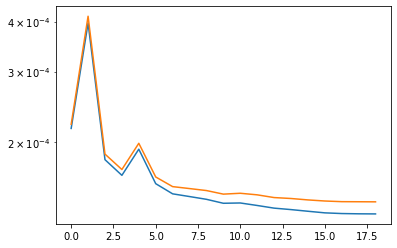

In [87]:
plt.semilogy(trnLoss[2:])
plt.semilogy(valLoss[2:])

[]

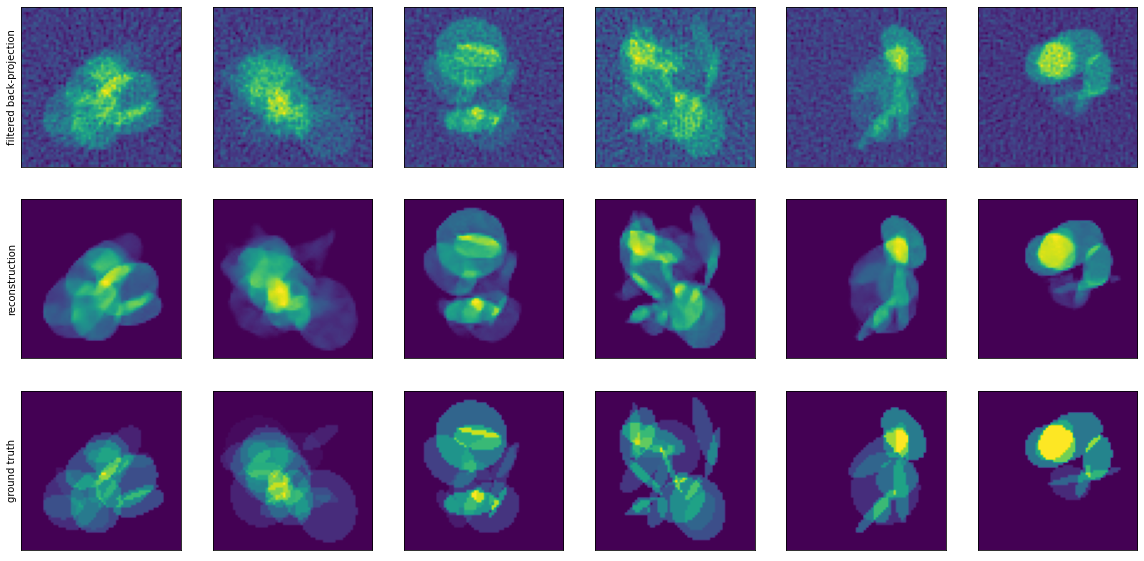

In [215]:
#results on validation data
hidden, resBlocks, kernel1, kernel2 = 10, 20, 9, 5
data = next(iter(trn_DL_varNoise))
data = FPandCUDA(data, "float", "cpu")
with torch.no_grad():
    model = FPandCUDA(postProcModel(hidden, resBlocks, kernel1, kernel2), "float", "cpu")
    model.load_state_dict(torch.load("postProcModel39checkpoint.pth.tar"))
rec = model(*data[:-1]).detach()
_, ax = plt.subplots(3, 6, figsize=(20, 10))
ax[0,0].set(ylabel="filtered back-projection")
ax[1,0].set(ylabel="reconstruction")
ax[2,0].set(ylabel="ground truth")
for i in range(6):
    ax[0,i].imshow(data[0][i, 0])
    ax[1,i].imshow(rec[i])
    ax[2,i].imshow(data[1][i])
plt.setp(ax, xticks=[], yticks=[])

torch.float32


[]

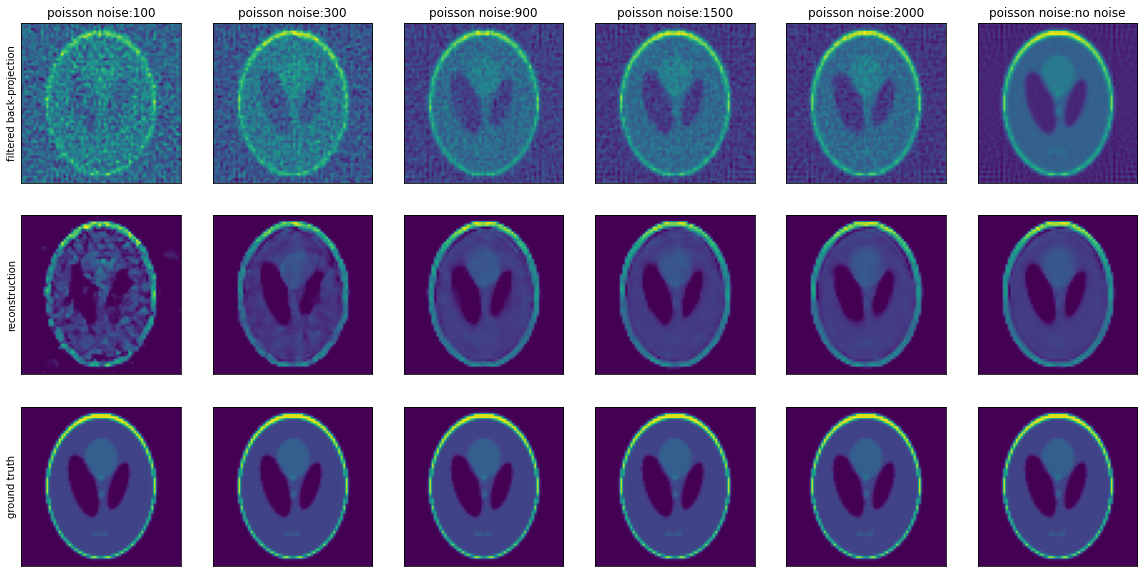

In [216]:
#results on test data with varying noise levels
rec = model(X).detach()
print(rec.dtype)
_, ax = plt.subplots(3, 6, figsize=(20, 10))
ax[0,0].set(ylabel="filtered back-projection")
ax[1,0].set(ylabel="reconstruction")
ax[2,0].set(ylabel="ground truth")
for i in range(6):
    ax[0, i].set_title("poisson noise:"+str(thetas[i]))
    ax[0,i].imshow(X[i, 0])
    ax[1,i].imshow(rec[i])
    ax[2,i].imshow(f64)
plt.setp(ax, xticks=[], yticks=[])